In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline 

# Modeling Mockup
Early in my exploration of datasets available through iNaturalist, I first began by exploring single users with a large number of datapoints. "gregtasney" was among the top contributors by observation to iNaturalist, with a little under 100,000 total observations. I had tried requesting users with closer to 200,000 observations but those requested failed multiple times. I assumed this was due to data size so I scaled down to around 100,000 observations, which is where Greg came in. This dataset was the first I'd downloaded and done preliminary exploration on. (As seen in 01_Greg_Prelim_Exploration). 

After a preliminary exploration of both Greg's and Eva's data, I decided on a different method of constructing a dataset for study (see Spicata_Clean_and_Prep), but also had ideas for how initial modeling for interpolation would work and wanted to do a proof-of-concept with this dataset before proceeding to ensure I really understood how the data worked with regards to modeling. 

The modeling idea here is to explore two questions:
Given a single plant observation:
    1) How well can the observations around it via the "time_observed_at" column accurately predict the lat/lon of the target observation using simple linear modeling?
    2) How many locations of observations around the target (via the "time_observed_at" column) would need to be obscured to protect the location of the target observation to a given standard (in this case I chose 100 m)?

In [2]:
data_gs = pd.read_csv("../../data/observations-gregtasney.csv")
data_gs.head()

C:\Users\lisa_\AppData\Local\Temp\ipykernel_49724\3933927287.py:1: DtypeWarning: Columns (15,26,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  data_gs = pd.read_csv("../../data/observations-gregtasney.csv")


,id,observed_on_string,observed_on,time_observed_at,time_zone,user_id,user_login,user_name,created_at,updated_at,...,place_county_name,place_state_name,place_country_name,place_admin1_name,place_admin2_name,species_guess,scientific_name,common_name,iconic_taxon_name,taxon_id
0,26102174,Sun May 26 2019 07:56:38 GMT+1000 (GMT+10),2019-05-26,2019-05-25 21:56:38 UTC,Brisbane,1809954,gregtasney,Greg Tasney,2019-05-31 06:25:48 UTC,2019-06-02 04:59:50 UTC,...,Salisbury,Queensland,Australia,Queensland,Salisbury,Argina astrea,Argina astrea,crotalaria pod borer,Insecta,318525.0
1,26102183,Sun May 19 2019 10:45:52 GMT+1000 (GMT+10),2019-05-19,2019-05-19 00:45:52 UTC,Brisbane,1809954,gregtasney,Greg Tasney,2019-05-31 06:26:15 UTC,2022-10-18 09:01:06 UTC,...,Corinda,Queensland,Australia,Queensland,Corinda,Lesser Wanderer,Danaus petilia,Lesser Wanderer,Insecta,333775.0
2,26102189,Sun May 19 2019 10:37:34 GMT+1000 (GMT+10),2019-05-19,2019-05-19 00:37:34 UTC,Brisbane,1809954,gregtasney,Greg Tasney,2019-05-31 06:26:36 UTC,2022-01-25 09:25:37 UTC,...,Corinda,Queensland,Australia,Queensland,Corinda,Blue Wanderer,Tirumala hamata,Blue Wanderer,Insecta,197078.0
3,26102706,NaN,NaN,NaN,Hawaii,1809954,gregtasney,Greg Tasney,2019-05-31 06:55:01 UTC,2023-04-27 13:22:35 UTC,...,Corinda,Queensland,Australia,Queensland,Corinda,Burnie Vine,Malaisia scandens,Burnie Vine,Plantae,705655.0
4,26102759,2019/05/01 8:04 PM HST,2019-05-01,2019-05-02 06:04:00 UTC,Hawaii,1809954,gregtasney,Greg Tasney,2019-05-31 06:57:25 UTC,2019-06-02 04:59:40 UTC,...,Salisbury,Queensland,Australia,Queensland,Salisbury,Argina astrea,Argina astrea,crotalaria pod borer,Insecta,318525.0


In [3]:
data_gs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97617 entries, 0 to 97616
Data columns (total 42 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                97617 non-null  int64  
 1   observed_on_string                97614 non-null  object 
 2   observed_on                       97614 non-null  object 
 3   time_observed_at                  97594 non-null  object 
 4   time_zone                         97617 non-null  object 
 5   user_id                           97617 non-null  int64  
 6   user_login                        97617 non-null  object 
 7   user_name                         97617 non-null  object 
 8   created_at                        97617 non-null  object 
 9   updated_at                        97617 non-null  object 
 10  quality_grade                     97617 non-null  object 
 11  license                           97617 non-null  object 
 12  url 

## Short and Dirty clean-up for mockup

In [4]:
# missing lat before drop
data_gs[data_gs["latitude"].isnull()].shape[0]

306

In [5]:
#dropping missing lat/long with confirm
data_gs.dropna(subset=['latitude'], inplace=True)
print(f'Number of null lat entries = {data_gs[data_gs["latitude"].isnull()].shape[0]}',
f'\nNumber of null long entries = {data_gs[data_gs["longitude"].isnull()].shape[0]}')

Number of null lat entries = 0 
Number of null long entries = 0


In [6]:
# checking time_observed_at after above drop
data_gs[data_gs["time_observed_at"].isnull()].shape[0]

22

In [7]:
# dropping missing observed time rows and confirming
data_gs.dropna(subset=['time_observed_at'], inplace=True)
print(f'Number of null time_observed_at entries = {data_gs[data_gs["latitude"].isnull()].shape[0]}')

Number of null time_observed_at entries = 0


In [8]:
# rechecking type of data for time observed
data_gs["time_observed_at"].map(type).value_counts()

<class 'str'>    97289
Name: time_observed_at, dtype: int64

In [9]:
data_gs["time_observed_at"] = pd.to_datetime(data_gs["time_observed_at"])
data_gs.head()

,id,observed_on_string,observed_on,time_observed_at,time_zone,user_id,user_login,user_name,created_at,updated_at,...,place_county_name,place_state_name,place_country_name,place_admin1_name,place_admin2_name,species_guess,scientific_name,common_name,iconic_taxon_name,taxon_id
0,26102174,Sun May 26 2019 07:56:38 GMT+1000 (GMT+10),2019-05-26,2019-05-25 21:56:38+00:00,Brisbane,1809954,gregtasney,Greg Tasney,2019-05-31 06:25:48 UTC,2019-06-02 04:59:50 UTC,...,Salisbury,Queensland,Australia,Queensland,Salisbury,Argina astrea,Argina astrea,crotalaria pod borer,Insecta,318525.0
1,26102183,Sun May 19 2019 10:45:52 GMT+1000 (GMT+10),2019-05-19,2019-05-19 00:45:52+00:00,Brisbane,1809954,gregtasney,Greg Tasney,2019-05-31 06:26:15 UTC,2022-10-18 09:01:06 UTC,...,Corinda,Queensland,Australia,Queensland,Corinda,Lesser Wanderer,Danaus petilia,Lesser Wanderer,Insecta,333775.0
2,26102189,Sun May 19 2019 10:37:34 GMT+1000 (GMT+10),2019-05-19,2019-05-19 00:37:34+00:00,Brisbane,1809954,gregtasney,Greg Tasney,2019-05-31 06:26:36 UTC,2022-01-25 09:25:37 UTC,...,Corinda,Queensland,Australia,Queensland,Corinda,Blue Wanderer,Tirumala hamata,Blue Wanderer,Insecta,197078.0
4,26102759,2019/05/01 8:04 PM HST,2019-05-01,2019-05-02 06:04:00+00:00,Hawaii,1809954,gregtasney,Greg Tasney,2019-05-31 06:57:25 UTC,2019-06-02 04:59:40 UTC,...,Salisbury,Queensland,Australia,Queensland,Salisbury,Argina astrea,Argina astrea,crotalaria pod borer,Insecta,318525.0
5,26102851,2019/04/28 9:28 AM HST,2019-04-28,2019-04-28 19:28:00+00:00,Hawaii,1809954,gregtasney,Greg Tasney,2019-05-31 07:01:49 UTC,2019-05-31 07:01:49 UTC,...,Salisbury,Queensland,Australia,Queensland,Salisbury,Poneridia semipullata,Poneridia semipullata,Figleaf Beetle,Insecta,520427.0


In [10]:
# checking type of data for time observed
data_gs["time_observed_at"].map(type).value_counts()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>    97289
Name: time_observed_at, dtype: int64

## Digging into Plantae data

Note: I used "positional_accuracy" here. Later exploration revealed that "public_positional_accuracy" is the correct category to use when modeling. It does not impact the "proof-of-concept" here, especially because the target species I chose, luckily had a public_positional_accuracy that matched its positional_accuracy

In [11]:
# number of Plantae observations with positional accuracy 30m or less
data_gs[(data_gs["iconic_taxon_name"] == 'Plantae') & (data_gs["positional_accuracy"] <= 30)].shape[0]

16007

In [12]:
# count of unique Plant species
data_gs[(data_gs["iconic_taxon_name"] == 'Plantae') & (data_gs["positional_accuracy"] <= 30)]['scientific_name'].value_counts().sort_values()

Tetrarrhena juncea                  1
Drosera trichocaulis                1
Briza maxima                        1
Eleocharis dulcis                   1
Labichea lanceolata brevifolia      1
                                 ... 
Parsonsia straminea               196
Cryptocarya triplinervis          198
Eucalyptus tereticornis           201
Elaeocarpus obovatus              204
Streblus brunonianus              276
Name: scientific_name, Length: 2267, dtype: int64

# Focus mock up on single entry as target observation

I chose "Tetrarrhena juncea" as the target observation because it was a "rare find" for this prolific user, making it a good imitation of an "endangered plant"

In [13]:
# chosen focus
data_gs[data_gs["scientific_name"] == "Tetrarrhena juncea"]

,id,observed_on_string,observed_on,time_observed_at,time_zone,user_id,user_login,user_name,created_at,updated_at,...,place_county_name,place_state_name,place_country_name,place_admin1_name,place_admin2_name,species_guess,scientific_name,common_name,iconic_taxon_name,taxon_id
25690,82817104,2021/06/13 10:35 AM AEST,2021-06-13,2021-06-13 00:35:00+00:00,Sydney,1809954,gregtasney,Greg Tasney,2021-06-13 10:41:05 UTC,2021-06-13 11:16:42 UTC,...,Gatton,Queensland,Australia,Queensland,Gatton,Forest Wire-grass,Tetrarrhena juncea,Forest Wire-grass,Plantae,802793.0


### Making dataset smaller for ease of looking at
Most of this not likely not needed in future iterations but worth considering run-times \
BUT ESSENTIAL IS:
- filtering according to positional accuracy standard
- sorting df values by time_observed_at
- reseting index after filtering

In [14]:
# narrow focus to columns most useful to interpolation
subset = data_gs[['id', 'time_observed_at',
                   'latitude', 'longitude',
                   'positional_accuracy', 'scientific_name',
                   'iconic_taxon_name']]

In [15]:
# narrow focus to observations with good positional accuracy
# and near the Tetrarrhena juncea in time
# sorting by time
subset = subset[(subset['time_observed_at'] >= '2021-06-12') & \
                (subset['time_observed_at'] < '2021-06-15') & \
                (subset["positional_accuracy"] <= 30)].sort_values(by="time_observed_at").reset_index()
subset

,index,id,time_observed_at,latitude,longitude,positional_accuracy,scientific_name,iconic_taxon_name
0,25568,82647368,2021-06-12 01:42:28+00:00,-27.449142,152.974412,16.0,Threskiornis spinicollis,Aves
1,25557,82639661,2021-06-12 02:36:20+00:00,-27.315333,152.746413,28.0,Leichhardtia rostrata,Plantae
2,25556,82639645,2021-06-12 02:36:43+00:00,-27.315297,152.746338,25.0,Flagellaria indica,Plantae
3,25555,82639615,2021-06-12 02:36:47+00:00,-27.315308,152.746338,18.0,Sarcopteryx stipata,Plantae
4,25553,82639557,2021-06-12 02:37:18+00:00,-27.315263,152.746247,28.0,Arytera distylis,Plantae
...,...,...,...,...,...,...,...,...
226,25817,83105143,2021-06-14 10:50:00+00:00,-27.743467,152.939575,7.0,Melia azedarach,Plantae
227,25819,83105145,2021-06-14 10:50:00+00:00,-27.743469,152.939544,7.0,Mallotus philippensis,Plantae
228,25820,83105146,2021-06-14 10:51:00+00:00,-27.743575,152.939147,6.0,Amyema,Plantae
229,25821,83105147,2021-06-14 10:53:00+00:00,-27.743783,152.938308,15.0,Acacia irrorata,Plantae


### Storing Time/Location about Target

In [16]:
# the min_from_beg for target prediction
TJ_time = subset.loc[subset["scientific_name"] == "Tetrarrhena juncea","time_observed_at"].iloc[0]
TJ_time

Timestamp('2021-06-13 00:35:00+0000', tz='UTC')

In [17]:
#store actual lat and lon for later evaluation of model accuracy
TJ_lat = subset.loc[subset["scientific_name"] == "Tetrarrhena juncea","latitude"].iloc[0]
TJ_lat

-27.5018

In [18]:
TJ_lon = subset.loc[subset["scientific_name"] == "Tetrarrhena juncea","longitude"].iloc[0]
TJ_lon

152.1263277778

### Renorming time for all other data in seconds away from target entry in new column

In [19]:
# creating time column where time is measured in minutes from the target datetime for TJ species
subset["sec_from_TJ"] = 0
for i in range(subset.shape[0]):
    sec_away = (subset["time_observed_at"][i] - TJ_time).total_seconds() 
    subset["sec_from_TJ"][i] = sec_away
subset

C:\Users\lisa_\AppData\Local\Temp\ipykernel_49724\865649831.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["sec_from_TJ"][i] = sec_away


,index,id,time_observed_at,latitude,longitude,positional_accuracy,scientific_name,iconic_taxon_name,sec_from_TJ
0,25568,82647368,2021-06-12 01:42:28+00:00,-27.449142,152.974412,16.0,Threskiornis spinicollis,Aves,-82352
1,25557,82639661,2021-06-12 02:36:20+00:00,-27.315333,152.746413,28.0,Leichhardtia rostrata,Plantae,-79120
2,25556,82639645,2021-06-12 02:36:43+00:00,-27.315297,152.746338,25.0,Flagellaria indica,Plantae,-79097
3,25555,82639615,2021-06-12 02:36:47+00:00,-27.315308,152.746338,18.0,Sarcopteryx stipata,Plantae,-79093
4,25553,82639557,2021-06-12 02:37:18+00:00,-27.315263,152.746247,28.0,Arytera distylis,Plantae,-79062
...,...,...,...,...,...,...,...,...,...
226,25817,83105143,2021-06-14 10:50:00+00:00,-27.743467,152.939575,7.0,Melia azedarach,Plantae,123300
227,25819,83105145,2021-06-14 10:50:00+00:00,-27.743469,152.939544,7.0,Mallotus philippensis,Plantae,123300
228,25820,83105146,2021-06-14 10:51:00+00:00,-27.743575,152.939147,6.0,Amyema,Plantae,123360
229,25821,83105147,2021-06-14 10:53:00+00:00,-27.743783,152.938308,15.0,Acacia irrorata,Plantae,123480


### Removing target entry from dataset, reseting index

In [20]:
#removing target TJ entry row to create model from remaining data
subset.drop(subset[subset["scientific_name"] == "Tetrarrhena juncea"].index, inplace = True)
subset.reset_index(inplace = True)

In [21]:
# double check
subset[subset["scientific_name"] == "Tetrarrhena juncea"]

,level_0,index,id,time_observed_at,latitude,longitude,positional_accuracy,scientific_name,iconic_taxon_name,sec_from_TJ


### Checking to see if the slice I'm looking at extends beyond geo cluster

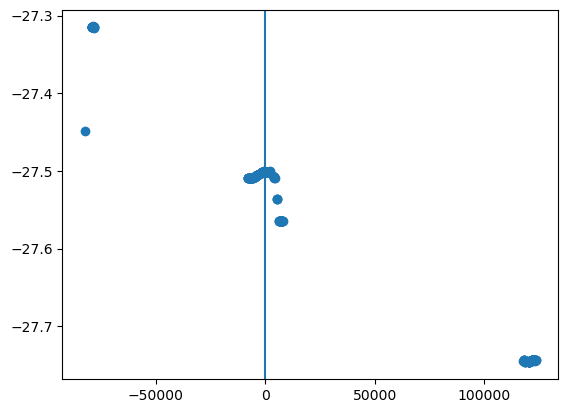

In [22]:
plt.figure()
plt.scatter(subset["sec_from_TJ"], subset["latitude"])
plt.axvline(x = 0)
plt.show()

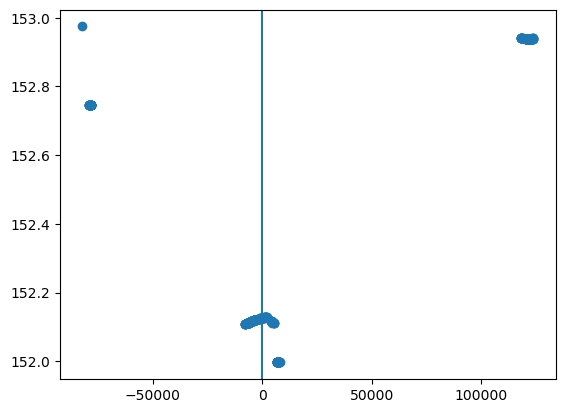

In [23]:
plt.figure()
plt.scatter(subset["sec_from_TJ"], subset["longitude"])
plt.axvline(x = 0)
plt.show()

## Code for models

Code for calculating distance between two places given lat and lon from
https://www.geeksforgeeks.org/program-distance-two-points-earth/ gives code below:

In [24]:
# Python 3 program to calculate Distance Between Two Points on Earth
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lat2, lon1, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a)) 
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)
     
     


In [25]:
# Creates empty dictionary for comparison of prediction models
model_predictions1 = {}

# creates list of columns for interpolation df
columns_for_interpolation = ["latitude", "longitude", "sec_from_TJ"]
    
# creates list of indices above and below target value given number of datapoints we want above 
# with presumption of number of above = number below

max_num_above = 50
for i in range(1, max_num_above + 1):
    index_above_target = subset[subset["sec_from_TJ"] > 0]["sec_from_TJ"].idxmin()
    desired_indices = [index_above_target]
    for j in range(1, i + 1):
        desired_indices.append(index_above_target - j)
        if j > 1:
            desired_indices.append(index_above_target + j)
        
# creates dataframe for only the chosen rows surrounding the target
    lin_reg_df = subset.loc[desired_indices, columns_for_interpolation]  

# creates independent columns with constant for lin reg analysis
    X_withconstant = sm.add_constant(lin_reg_df["sec_from_TJ"])

# creates dependent columns for latitude and longitude
    yLAT = lin_reg_df["latitude"]
    yLON = lin_reg_df["longitude"]

# instantiates and fits one OLS for dependent of latitude and another for longitude
    lin_reg_resultsLAT = sm.OLS(yLAT, X_withconstant).fit()
    lin_reg_resultsLON = sm.OLS(yLON, X_withconstant).fit() 

# calculates how far prediction is from actual
    meters_from_actual = 1000 * distance(lin_reg_resultsLAT.params[0], TJ_lat, lin_reg_resultsLON.params[0], TJ_lon)

# stores predictions in model prediction dictionary with relevant assessment data
    model_predictions1[i-1] = (i*2,
                            lin_reg_resultsLAT.params[0], 
                            lin_reg_resultsLAT.pvalues[0],
                            lin_reg_resultsLAT.rsquared,
                            lin_reg_resultsLON.params[0], 
                            lin_reg_resultsLON.pvalues[0],
                            lin_reg_resultsLON.rsquared,
                            meters_from_actual)

# turns dictionary into dataframe
col_for_df = ["num_datapoints", "predicted_lat", "const_pvalue_lat", "rsquared_lat", "predicted_lon", "const_pvalue_lon", "rsquared_lon", "meters_from_actual"]
model_predictions1_df = pd.DataFrame.from_dict(model_predictions1, orient="index", columns = col_for_df)


In [26]:
model_predictions1_df

,num_datapoints,predicted_lat,const_pvalue_lat,rsquared_lat,predicted_lon,const_pvalue_lon,rsquared_lon,meters_from_actual
0,2,-27.501755,NaN,1.000000,152.126271,NaN,1.000000,7.515633
1,4,-27.501716,3.948097e-12,0.527855,152.126337,8.108650e-14,0.776654,9.345812
2,6,-27.501691,1.764524e-22,0.061037,152.126386,4.396697e-26,0.782423,13.438721
3,8,-27.501627,4.392002e-32,0.311390,152.126424,3.067905e-38,0.787870,21.453190
4,10,-27.501572,3.350020e-42,0.323750,152.126510,6.071346e-47,0.631904,31.085906
5,12,-27.501524,3.075035e-52,0.320655,152.126600,1.490707e-56,0.677549,40.719304
6,14,-27.501492,1.871176e-62,0.322463,152.126670,2.647617e-67,0.727976,48.063026
7,16,-27.501452,2.490533e-72,0.278528,152.126746,9.979485e-78,0.764214,56.504572
8,18,-27.501415,5.494093e-82,0.144111,152.126833,2.754199e-88,0.772469,65.691274
9,20,-27.501388,1.046870e-91,0.041749,152.126891,4.027373e-99,0.782967,71.965074


For this target observation, the best predictor comes from the most simple interpolation--using only the two locations on either side of the observation. This makes sense because, although including 100 data points might better model the entire "walk" or location of the user over time, the higher the proximity of an observation to the target, the better those observations will be at predicting the very specific target. 

### How much does interpolation get thrown off as we obscure data with times near the target location? 

Applying the information above, and for simplicity, I answer this question using only the two "closest" data point--basic interpolation between two points. Two by two, I remove observations on either side of the target and reperform the linear interpolation given the two "closest points" (by "time_observed_at") left remaining in the data set.

In [27]:
# Creates empty dictionary for comparison of prediction models
model_predictions2 = {}

# creates list of columns for interpolation df
columns_for_interpolation = ["latitude", "longitude", "sec_from_TJ"]
    
# finds the indices of the two data points i steps above and below target

max_num_above = 50
for i in range(1, max_num_above + 1):
    index_above_target = subset[subset["sec_from_TJ"] > 0]["sec_from_TJ"].idxmin()
    desired_indices = [index_above_target - i, index_above_target - 1 + i]


# creates dataframe for only the chosen rows surrounding the target
    lin_reg_df = subset.loc[desired_indices, columns_for_interpolation]  

# creates independent columns with constant for lin reg analysis
    X_withconstant = sm.add_constant(lin_reg_df["sec_from_TJ"])

# creates dependent columns for latitude and longitude
    yLAT = lin_reg_df["latitude"]
    yLON = lin_reg_df["longitude"]

# instantiates and fits one OLS for dependent of latitude and another for longitude
    lin_reg_resultsLAT = sm.OLS(yLAT, X_withconstant).fit()
    lin_reg_resultsLON = sm.OLS(yLON, X_withconstant).fit() 

# calculates how far prediction is from actual
    meters_from_actual = 1000 * distance(lin_reg_resultsLAT.params[0], TJ_lat, lin_reg_resultsLON.params[0], TJ_lon)

# stores predictions in model prediction dictionary with relevant assessment data
    model_predictions2[i-1] = (i*2 - 1,
                            lin_reg_resultsLAT.params[0], 
                            lin_reg_resultsLON.params[0], 
                            meters_from_actual)

# turns dictionary into dataframe
col_for_df = ["num_obs_obscured", "predicted_lat", "predicted_lon", "meters_from_actual"]
model_predictions2_df = pd.DataFrame.from_dict(model_predictions2, orient="index", columns = col_for_df)

In [28]:
model_predictions2_df

,num_obs_obscured,predicted_lat,predicted_lon,meters_from_actual
0,1,-27.501755,152.126271,7.515633
1,3,-27.501661,152.126366,15.903530
2,5,-27.501718,152.126457,15.662810
3,7,-27.501530,152.126534,36.270741
4,9,-27.501292,152.126635,64.052943
5,11,-27.501274,152.126979,86.842775
6,13,-27.501277,152.127182,102.323455
7,15,-27.501168,152.127293,118.338855
8,17,-27.501075,152.127628,151.470896
9,19,-27.501142,152.127561,141.926060


For this target observation, we would have to obscure the locations of 7 observations (3 on either side of the target and the target itself) before protecting the target observation's location at threshold of 50m and 27 observations would need locations obscured if the threshold was 100m. 

The idea would be to repeat this same analysis over many different target species to build a meta-dataset of answers to these questions for further study.